In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from dgr_bert_model import *
from dgr_vae_model import *
from dgr_utils import *
from dgr_linear_classifier import *

In [3]:
# Use GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
print("Available device: {}".format(device))
if use_cuda:
    print(torch.cuda.get_device_name(0))

Available device: cuda:0
NVIDIA GeForce GTX 1070


In [ ]:
"""
Features are generated with the VAE model and labeled with the FeatureClassifier
A LinearClassifier is trained using the generated features and labels
Best F1 score: 0.854

generated_features <- VAE.decode(random_seed())
generated_labels <- FeaureClassifier(generated_features)
linear_model <- train_linear_model(generated_features, generated_labels)
"""

In [4]:
bert_lstm = torch.load('data/model_bert_854.pth')

feature_extractor = torch.load('data/feature_extractor.pth')
feature_classifier = torch.load('data/feature_classifier.pth')

vae = torch.load('data/vae.pth')

In [5]:
train_features_sample = torch.load('data/train_features_sample.pt')
train_features_label = torch.load('data/train_features_label.pt')

val_features_sample = torch.load('data/val_features_sample.pt')
val_features_label = torch.load('data/val_features_label.pt')

In [6]:
def generate_samples(vae, num_samples):
    vae.eval()

    # Generate samples
    with torch.no_grad():
        latent_samples = torch.randn(num_samples, vae.latent_dim).to(device)
        generated_samples = vae.decoder(latent_samples)

    return generated_samples

In [7]:
generated_samples = generate_samples(vae, 10000)

In [8]:
print(generated_samples.shape)

torch.Size([10000, 1024])


In [9]:
pred = feature_classifier(generated_samples)
generated_labels = torch.argmax(pred, dim=1)

In [10]:
print(generated_labels.shape)

torch.Size([10000])


In [11]:
counts = torch.bincount(generated_labels)
print(counts)

tensor([5433, 3357, 1210], device='cuda:0')


In [12]:
batch_size = 32

generated_dataset = TensorDataset(generated_samples, generated_labels)
generated_dataset_sampler = RandomSampler(generated_dataset)
generated_train_dataloader = DataLoader(generated_dataset,
                                        sampler=generated_dataset_sampler,
                                        batch_size=batch_size)

In [13]:
val_features_dataset = TensorDataset(val_features_sample, val_features_label)
val_features_sampler = RandomSampler(val_features_dataset)
val_features_dataloader = DataLoader(val_features_dataset,
                                     sampler=val_features_sampler,
                                     batch_size=batch_size)

In [14]:
generated_model = LinearClassifier()
generated_model.to(device)
print(generated_model)

ReplayClassifier(
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (dropout1): Dropout(p=0.5, inplace=False)
  (relu1): ReLU()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (dropout2): Dropout(p=0.5, inplace=False)
  (relu2): ReLU()
  (fc3): Linear(in_features=128, out_features=3, bias=True)
  (dropout3): Dropout(p=0.5, inplace=False)
  (softmax): LogSoftmax(dim=1)
)


In [15]:
class_weights = torch.tensor([1 / counts[0].item(),
                              1 / counts[1].item(),
                              1 / counts[2].item()]).to(device)

# define the loss function
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(generated_model.parameters(), lr=0.0005)

In [16]:
evaluate_linear(generated_model, val_features_dataloader, device)

100%|██████████| 59/59 [00:00<00:00, 491.19it/s]


0.3185348078223332

In [17]:
num_epochs = 25

results = train_linear(generated_model,
                generated_train_dataloader, val_features_dataloader,
                optimizer, criterion, num_epochs, device,
                verbose=True)

Total Training Time (total number of epochs: 25)


100%|██████████| 59/59 [00:00<00:00, 831.20it/s]


saving model checkpoint to data/replay_model.pth
[Epoch 1] loss:	124.769, f1 train: 0.989, f1 test: 0.851 


100%|██████████| 59/59 [00:00<00:00, 830.97it/s]


[Epoch 2] loss:	105.742, f1 train: 0.995, f1 test: 0.850 


100%|██████████| 59/59 [00:00<00:00, 797.29it/s]


[Epoch 3] loss:	102.749, f1 train: 0.990, f1 test: 0.849 


100%|██████████| 59/59 [00:00<00:00, 819.11it/s]


[Epoch 4] loss:	105.940, f1 train: 0.995, f1 test: 0.850 


100%|██████████| 59/59 [00:00<00:00, 786.68it/s]


saving model checkpoint to data/replay_model.pth
[Epoch 5] loss:	104.886, f1 train: 0.994, f1 test: 0.854 


100%|██████████| 59/59 [00:00<00:00, 808.21it/s]


[Epoch 6] loss:	103.245, f1 train: 0.990, f1 test: 0.852 


100%|██████████| 59/59 [00:00<00:00, 786.70it/s]


[Epoch 7] loss:	102.553, f1 train: 0.994, f1 test: 0.852 


100%|██████████| 59/59 [00:00<00:00, 855.09it/s]


[Epoch 8] loss:	101.688, f1 train: 0.991, f1 test: 0.851 


100%|██████████| 59/59 [00:00<00:00, 842.86it/s]


[Epoch 9] loss:	101.638, f1 train: 0.994, f1 test: 0.851 


100%|██████████| 59/59 [00:00<00:00, 819.42it/s]


[Epoch 10] loss:	103.590, f1 train: 0.996, f1 test: 0.850 


100%|██████████| 59/59 [00:00<00:00, 880.59it/s]


[Epoch 11] loss:	100.395, f1 train: 0.997, f1 test: 0.849 


100%|██████████| 59/59 [00:00<00:00, 855.07it/s]


[Epoch 12] loss:	101.069, f1 train: 0.995, f1 test: 0.847 


100%|██████████| 59/59 [00:00<00:00, 880.61it/s]


[Epoch 13] loss:	102.666, f1 train: 0.998, f1 test: 0.851 


100%|██████████| 59/59 [00:00<00:00, 808.21it/s]


[Epoch 14] loss:	99.209, f1 train: 0.995, f1 test: 0.849 


100%|██████████| 59/59 [00:00<00:00, 855.08it/s]


[Epoch 15] loss:	104.037, f1 train: 0.997, f1 test: 0.849 


100%|██████████| 59/59 [00:00<00:00, 808.09it/s]


[Epoch 16] loss:	99.954, f1 train: 0.997, f1 test: 0.851 


100%|██████████| 59/59 [00:00<00:00, 907.73it/s]


[Epoch 17] loss:	100.119, f1 train: 0.995, f1 test: 0.851 


100%|██████████| 59/59 [00:00<00:00, 879.22it/s]


[Epoch 18] loss:	100.954, f1 train: 0.991, f1 test: 0.848 


100%|██████████| 59/59 [00:00<00:00, 842.55it/s]


[Epoch 19] loss:	100.882, f1 train: 0.996, f1 test: 0.848 


100%|██████████| 59/59 [00:00<00:00, 867.28it/s]


[Epoch 20] loss:	102.190, f1 train: 0.990, f1 test: 0.848 


100%|██████████| 59/59 [00:00<00:00, 807.96it/s]


[Epoch 21] loss:	100.724, f1 train: 0.993, f1 test: 0.852 


100%|██████████| 59/59 [00:00<00:00, 907.32it/s]


[Epoch 22] loss:	100.609, f1 train: 0.992, f1 test: 0.850 


100%|██████████| 59/59 [00:00<00:00, 819.75it/s]


[Epoch 23] loss:	101.252, f1 train: 0.996, f1 test: 0.850 


100%|██████████| 59/59 [00:00<00:00, 819.43it/s]


[Epoch 24] loss:	99.250, f1 train: 0.995, f1 test: 0.850 


100%|██████████| 59/59 [00:00<00:00, 867.66it/s]

[Epoch 25] loss:	99.105, f1 train: 0.992, f1 test: 0.848 


In [20]:
eval_model = torch.load("data/replay_model.pth")

In [22]:
y_true_val, y_pred_val = [], []
for x, y in val_features_dataloader:
    x, y = x.to(device), y.to(device)
    
    log_probs = eval_model(x)
    
    y_batch_pred = torch.argmax(log_probs, dim=1)
    
    y_true_val += list(y.cpu().numpy())
    y_pred_val += list(y_batch_pred.cpu().numpy())

Evaluation on Validation dataset
F1 score: 0.854


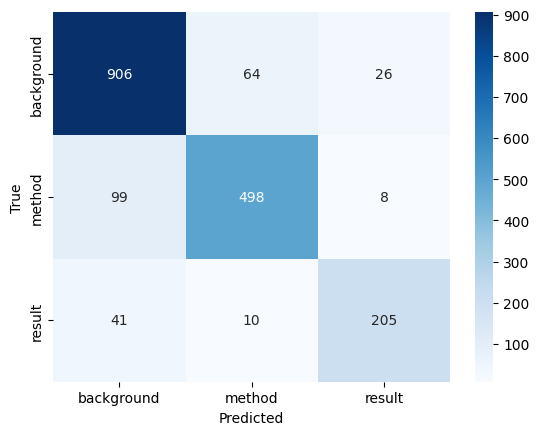

              precision    recall  f1-score   support

  background       0.87      0.91      0.89       996
      method       0.87      0.82      0.85       605
      result       0.86      0.80      0.83       256

    accuracy                           0.87      1857
   macro avg       0.86      0.84      0.85      1857
weighted avg       0.87      0.87      0.87      1857


In [23]:
label_list = ['background', 'method', 'result']

f1_eval = f1_score(y_true_val, y_pred_val, average='macro')
cm_eval = confusion_matrix(y_true_val, y_pred_val)
report = classification_report(y_true_val, y_pred_val, target_names=label_list)

print("Evaluation on Validation dataset")
print('F1 score: {:.3f}'.format(f1_eval))

sns.heatmap(cm_eval, annot=True, fmt='d', cmap='Blues', xticklabels=label_list, yticklabels=label_list)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

print(report)